In [ ]:
# preprocess of synthetic data, including NSCLC tissue structure and corresonding single-cell proteomics data
# Yuan
# 20241119

In [36]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Preprocess and visualization of single-cell proteomics data
- Fig. S2c
- Fig. S2d

         Falling back to preprocessing with `sc.pp.pca` and default params.


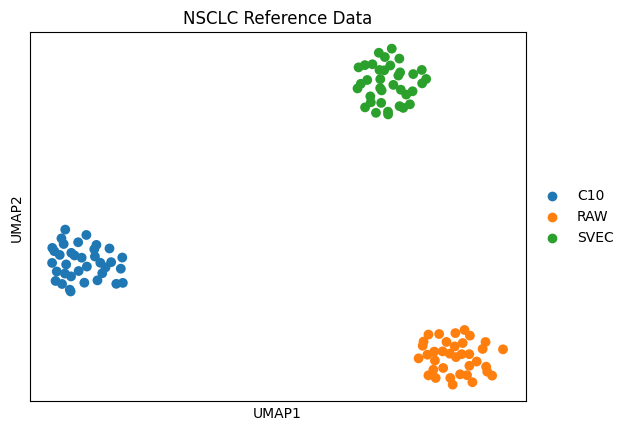

In [80]:
# Preprocess of NSCLC reference single-cell proteomics data [scp2021]
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/NSCLC2019/00_raw")

data_df = pd.read_excel("scp2021.xlsx",index_col=0) # LFQ Quantified
meta_df = pd.read_excel("scp2021_meta.xlsx", index_col=0)

data_df.fillna(0, inplace=True)
reference_adata = sc.AnnData(X=csr_matrix(np.array(data_df.T)), obs=meta_df)
reference_adata.obs.index = reference_adata.obs.SampleID
reference_adata.var_names = data_df.index

reference_adata.obs["celltype"] = reference_adata.obs.Group
reference_adata.obs.celltype = reference_adata.obs.celltype.astype('category')
reference_adata.write_h5ad("scp2021_1437_Reference.h5ad") # save as h5ad

sc.pp.normalize_total(reference_adata)
sc.pp.log1p(reference_adata)
sc.pp.scale(reference_adata)

sc.pp.neighbors(reference_adata)
sc.tl.umap(reference_adata)

sc.pl.umap(reference_adata, color=['celltype'],size=200,title="NSCLC Reference Data", save=" NSCLC Reference Data") # for Fig. S2c

         Falling back to preprocessing with `sc.pp.pca` and default params.


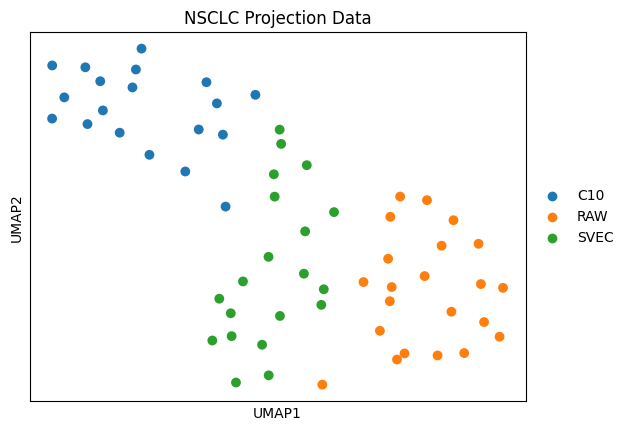

In [81]:
# Preprocess of NSCLC reference single-cell proteomics data [scp2019]
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/NSCLC2019/00_raw")

data_df = pd.read_excel("scp2019.xlsx",index_col=0) # LFQ Quantified
meta_df = pd.read_excel("scp2019_meta.xlsx", index_col=0)

data_df.fillna(0, inplace=True)
projection_adata = sc.AnnData(X=csr_matrix(np.array(data_df.T)), obs=meta_df)
projection_adata.obs.index = projection_adata.obs.SampleID
projection_adata.var_names = data_df.index

projection_adata.obs["celltype"] = projection_adata.obs.Group
projection_adata.obs.celltype = projection_adata.obs.celltype.astype('category')
projection_adata.write_h5ad("scp2019_1225_Projection.h5ad") # save as h5ad

sc.pp.normalize_total(projection_adata)
# sc.pp.log1p(projection_adata)
# sc.pp.scale(projection_adata)

sc.pp.neighbors(projection_adata)
sc.tl.umap(projection_adata)

sc.pl.umap(projection_adata, color=['celltype'],size=200,title="NSCLC Projection Data", save=" NSCLC Projection Data") # for Fig. S2d

In [34]:
# Intersect the two datasets for deconvolution
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/NSCLC2019/00_raw")
projection_adata = sc.read_h5ad("scp2019_1225_Projection.h5ad")
reference_adata = sc.read_h5ad("scp2021_1437_Reference.h5ad")

intersect_id = np.intersect1d(projection_adata.var_names,reference_adata.var_names)
projection_adata[:,intersect_id].write_h5ad("scp2019_1003_Projection.h5ad")
reference_adata[:,intersect_id].write_h5ad("scp2021_1003_Reference.h5ad")

# Preprocess and visualization of NSCLC tissue structure data
- Fig. 2b and S2b

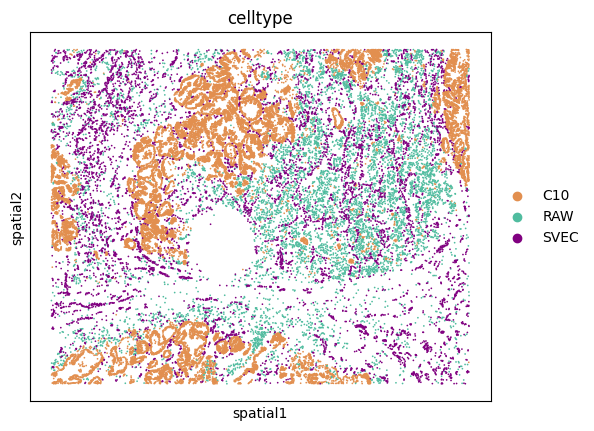

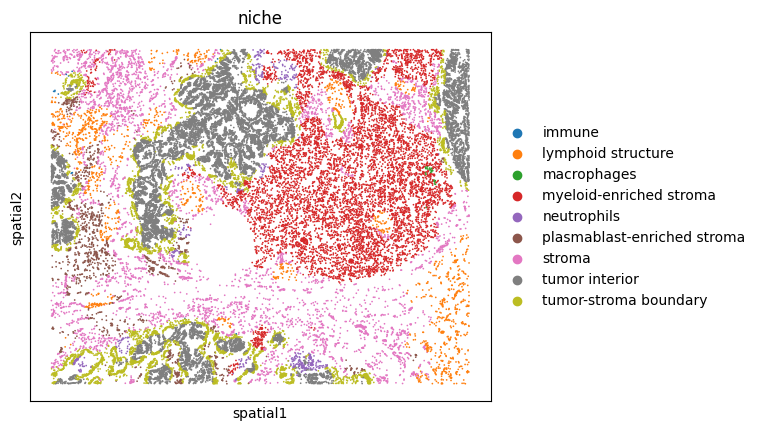

In [83]:
# vis of cell-type distribution and construction of empty adata
# For Fig. 2b and S2b
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/NSCLC2019/00_raw")

sp_meta_df = pd.read_csv("sp_meta.csv", index_col=0)
sp_loc_df = pd.read_csv("spatial_loca_raw.csv", index_col=0)

sp_meta_df[["x","y"]] = sp_loc_df[["sdimx","sdimy"]].values * 100
sp_meta_df["celltype"] = sp_meta_df["cell_type"]

empty_adata = sc.AnnData(X=csr_matrix(np.ones([sp_meta_df.shape[0],10])), obs=sp_meta_df)

# begin filter
empty_adata = empty_adata[empty_adata.obs["patient"] == "Lung5"]
empty_adata = empty_adata[empty_adata.obs["Run_Tissue_name"] == "Lung5_Rep1"]
empty_adata = empty_adata[empty_adata.obs["celltype"].isin(["macrophage","tumor 5","endothelial"])]

# sort and order
empty_adata.obs["celltype"][empty_adata.obs["celltype"] == "tumor 5"] = "C10"#"Group1" #C10
empty_adata.obs["celltype"][empty_adata.obs["celltype"] == "macrophage"] = "RAW"#"Group2" #RAW
empty_adata.obs["celltype"][empty_adata.obs["celltype"] == "endothelial"] = "SVEC"#"Group3" # SVEC
empty_adata.obs["celltype"] = empty_adata.obs["celltype"].astype("category")

empty_adata.obs.sort_values('celltype', ascending=True, inplace=True)
empty_adata.obsm["spatial"] = np.array(empty_adata.obs[['x', 'y']])

# empty_adata.write_h5ad("NSCLC_ct3_scp_empty_Lung5_R1.h5ad") # save for later use

# vis of scp adata for mixed
sc.pl.spatial(empty_adata, spot_size=2, color=["celltype"],palette=['#E28F4F','#50BC9F','purple'], save=" tissue structure.pdf") # for Fig. 2b
sc.pl.spatial(empty_adata, spot_size=2, color=["niche"], save=" tissue niches.pdf") # for Fig. S2b

In [ ]:
# Map each cells of NSCLC tissue structure with the NSCLC projection proteomics data
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/NSCLC2019/00_raw")

def empty_project_scp(empty_adata, scp_adata, celltype_order="celltype"):
    
    sc_data = pd.DataFrame(scp_adata.X.toarray(), index=scp_adata.obs[celltype_order], columns=scp_adata.var.index)
    sc_data["celltype_simu"] = sc_data.index
    sc_data.index = range(len(sc_data))

    celltype_groups = sc_data.groupby("celltype_simu").groups    
    for key, value in celltype_groups.items():
        celltype_groups[key] = np.array(value)
    allcellname = celltype_groups.keys()
    sc_data.drop(columns=["celltype_simu"], inplace=True)
    sc_data = ad.AnnData(sc_data)
    sc_data = sc_data.X
    sc_data = np.ascontiguousarray(sc_data, dtype=np.float32)
    
    sample_count = pd.DataFrame(empty_adata.obs[celltype_order].value_counts()) 
    
    projection_value = []
    for j, cellname in enumerate(allcellname): # 遍历cell types
        select_index = np.random.choice(celltype_groups[cellname], size=int(sample_count.loc[cellname]["count"]), replace=True)
        if (len(projection_value)  == 0):
            projection_value = sc_data[select_index]
        else:
            projection_value = np.concatenate((projection_value, sc_data[select_index]))
    print(projection_value.shape)
    projection_scp_adata = sc.AnnData(X=csr_matrix(projection_value), obs=empty_adata.obs)
    projection_scp_adata.obsm["spatial"] = empty_adata.obsm["spatial"]
    projection_scp_adata.var_names = scp_adata.var_names    

    return(projection_scp_adata)

empty_adata_for_projection = sc.read_h5ad("NSCLC_ct3_scp_empty_Lung5_R1.h5ad")               
scp_adata_for_projection = sc.read_h5ad("scp2019_1003_Reference.h5ad")
projection_scp_adata = empty_project_scp(empty_adata=empty_adata_for_projection, scp_adata=scp_adata_for_projection)

projection_scp_adata.write_h5ad("NSCLC_ct3_scp_Lung5_R1_scp2019.h5ad") # after projection

In [ ]:
# Obtain synthetic spot-level spatial proteomics data
# Add Noise for both reference data and spatial proteomics data
## Perform with python scripts

# Visualization and analysis of synthetic NSCLC data

In [15]:
# Calculate the average cell densities within synthetic spots
# For Supp. Table.
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/Ablation_study/NSCLC_cond3/01_data/simulations/synthetic_cellnum_noise_v4")

for window in [10,15,20]:
    cell_count_df = pd.read_csv(f"Simu_seed0_cells{window}_noise0_combined_cell_counts.csv",index_col=0)
    average_count = np.mean(cell_count_df["cell_count"])
    print(f"Average cell count for window [{window}] is: {int(average_count)}, which consists of {len(cell_count_df)} spots")

Average cell count for window [10] is: 17, which consists of 1917 spots
Average cell count for window [15] is: 36, which consists of 900 spots
Average cell count for window [20] is: 66, which consists of 495 spots


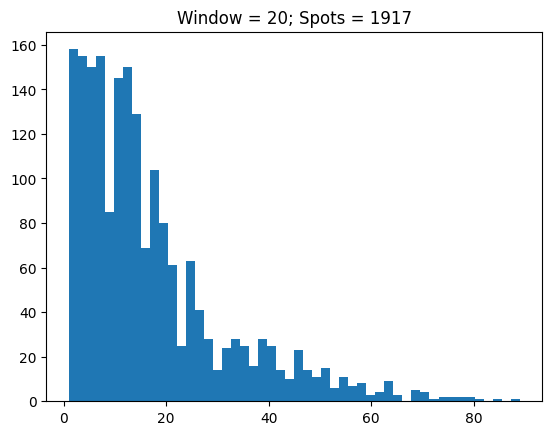

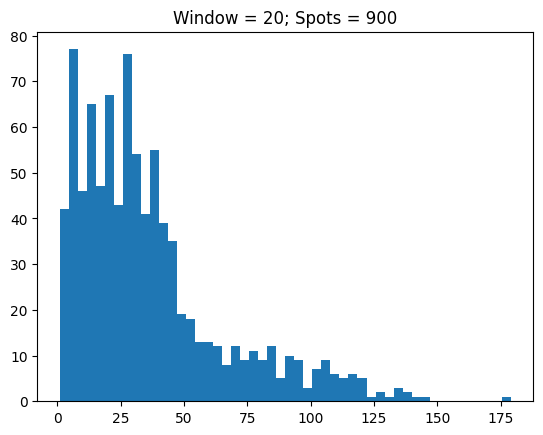

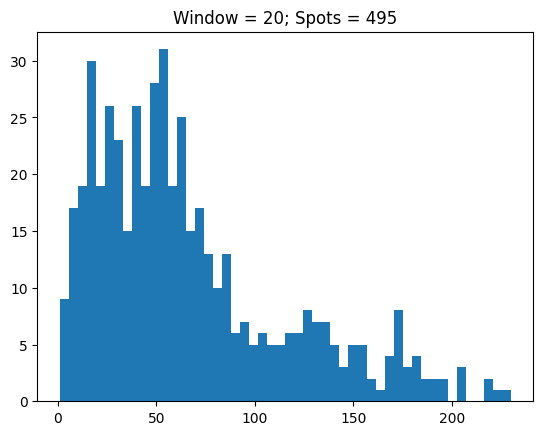

In [16]:
# Vis of the average cell densities within synthetic spots
# NOT Used
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/Ablation_study/NSCLC_cond3/01_data/simulations/synthetic_cellnum_noise_v4")

for window in [10,15,20]:
    cell_count_df = pd.read_csv(f"Simu_seed0_cells{window}_noise0_combined_cell_counts.csv",index_col=0)
    
    plt.hist(cell_count_df["cell_count"], bins=50)
    plt.title(f'Window = {cellnums}; Spots = {cell_count_df.shape[0]}')
    plt.show()
